# Caso Práctico: Optimización de Campañas de Marketing Mediante el Bandido Multibrazo

El problema del bandido multibrazo es un problema del aprendizaje por refuerzo basado en el juego de las máquinas tragaperras. El objetivo de este problema consiste en jugar P partidas a K tragaperras y obtener el mayor beneficio posible. Para ello se necesita encontrar la distribución de las recompensas de las diferentes tragaperras, para saber en qué máquinas jugar la mayor parte del tiempo para obtener las mayores recompensas.

Definimos como **Q(a)** a la recompensa media recibida por partida en la tragaperras **a** de la siguiente forma:

$$Q(a) = \frac{R_a}{N_a}$$

dónde: 
- $R_a$ : suma de las recompensas de la tragaperras **a**.
- $N_a$ : número de partidas jugadas a la tragaperras **a**.

El objetivo es encontrar la tragaperras que más recompensas ofrece, $máx. {Q(a)}$, o mejor dicho para el caso práctico que nos atañe, encontrar el *banner* publicitario que más clics va a brindarnos, $máx. {Q(imagen_i)}$:

$$Q(imagen_i) = \frac{Nº\ clics}{Nº\ impresiones\ de\ la\ página} $$

La política de exploración y explotación empleada para encontrar ese *banner* que máximiza el retorno se conoce como ***epsilon-greedy***: consiste en que el sistema explorará opciones al azar con probabilidad $\epsilon$ y explotará la opción más provechosa con probabilidad $1-\epsilon$.

### Apartado 1

Así pues, nuestra primera labor consiste en encontrar el valor de $\epsilon$ que maximiza la imagen con mayor número de clics. Primero necesitamos definir las funciones de nuestro *notebook*.

In [1]:
# Importamos las librerías necesarias
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode, wilcoxon


# Función que genera los bandidos
def gen_bandits():
    """
    Función que devuelve una lista de probabilidades ordenadas al azar
    En esta lista se encuentra la probabilidad de premio de cada "tragaperras"
    """
    bandits = [0.1, 0.1, 0.1, 0.2, 0.6]
    random.shuffle(bandits)
    return bandits
    

# Función que juega con los bandidos
def multi_armed_bandit(num_games=1000, epsilon=0.1, verbose=False):
    
    bandits = gen_bandits()
    total_reward = 0
    acum_reward_bandit = np.zeros(len(bandits))  # numerador
    num_selected_bandit = np.zeros(len(bandits)) # denominador
    q_bandits = np.zeros(len(bandits))            # Q(a)
    
    if verbose:
        print("Initial Bandits Distribution\n  {}".format(bandits))
    
    for game in range(0,num_games):
        
        # Hago una copiar de los Q(a)
        old_q_bandits = q_bandits.copy()
        
        # Selecciono "tragaperras" a la que jugar
        if np.random.random() < epsilon:
            bandit = np.random.randint(len(bandits)) # Exploro
        else:
            bandit = np.random.choice(np.flatnonzero(q_bandits == q_bandits.max())) # Exploto 
            
        # Obtengo el reward
        reward = 1 if (np.random.random() < bandits[bandit]) else 0
        
        # Actualizo reward total
        total_reward += reward
        
        # Actualizo valor (Q) de la "tragaperras"
        acum_reward_bandit[bandit] += reward
        num_selected_bandit[bandit] += 1
        q_bandits[bandit] = acum_reward_bandit[bandit] / num_selected_bandit[bandit]
        
        if verbose:
            print("\nGAME {game}\n  Old Q_Bandits = {old_q_bandits}\n  Selected Bandit = {bandit} \
                  \n  Reward = {reward}\n  Q_Bandits = {q_bandits}"
                  .format(game=game+1, old_q_bandits=old_q_bandits, bandit=bandit, 
                          reward=reward, q_bandits=q_bandits))
    
    return bandits, total_reward, q_bandits, num_selected_bandit


Encontrar el valor de $\epsilon$ que maximiza la imagen con mayor número de clics es equivalente a seleccionar la imagen que más recompensas totales ofrece. Por lo tanto, encontrar ese valor ayuda a maximizar el ROI (*Return of Investment*) de nuestra campaña de marketing.

En la gráfica de abajo podemos ver como la recompensa total media, la recompensa de todas las máquinas combinadas, es mayor generalmente cuantas más veces se selecciona la máquina más ventajosa.

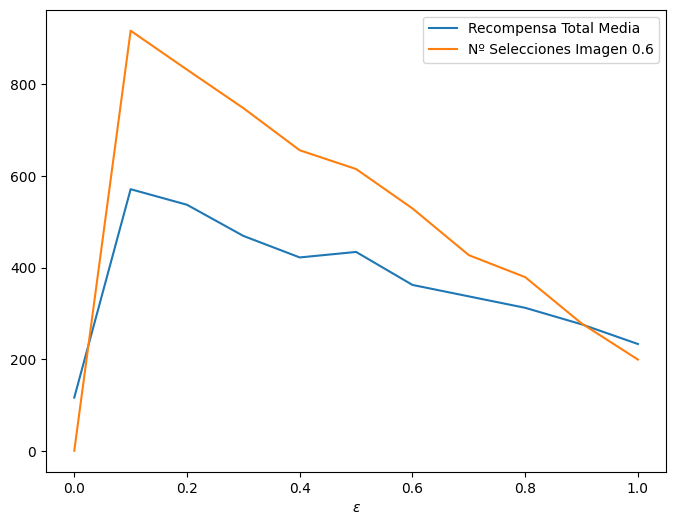

In [2]:
epsilons = np.linspace(0, 1, 11) # Array con valores de "epsilon"
mean_rewards = [] # Lista vacía para almacenar las recompensas totales
n_selected_06 = [] # Lista vacía para almacenar el número de veces que se selecciona el bandido de recompensa 0.6

for ep in epsilons:
    bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000,
                                                                                       epsilon=ep,
                                                                                       verbose=False)
    mean_rewards.append(total_reward)
    n_selected_06.append(num_selected_bandit[np.array(bandits) == 0.6])

plt.figure(figsize = (8,6))
plt.plot(epsilons, mean_rewards, label = "Recompensa Total Media")
plt.plot(epsilons, n_selected_06, label = "Nº Selecciones Imagen 0.6")
plt.xlabel("$\epsilon$")
plt.legend()

No obstante, para este ejercicio nosotros no sabremos *a priori* qué imagen es la que capta mayor atención. Debemos descubrirlo en función de las recompensas (clics) obtenidas.

Un inconveniente con el que podemos encontrarnos parte de la propia naturaleza del ejercicio y las variables seleccionadas. En nuestro algoritmo contamos con 5 imágenes (5 tragaperras), cada una de ellas con una cierta probabilidad de ofrecer una recompensa. Cuando la cantidad de clases es baja y las recompensas están altamente desbalanceadas, es posible que el sistema termine premiando una cantidad de exploración muy baja porque el riesgo de seleccionar inicialmente al azar la imagen que ofrece las mayores recompensas es asumible. Sin embargo, sabemos que en cualquier problema del bandido multibrazo siempre es recomendable una mínima exploración, pues la tasa de exploración nula ($\epsilon = 0$) suele ser la peor estrategia a largo plazo.

Para resolver este inconveniente, repetiremos una simulación como la de arriba "n_sim" veces. Esto promediará los efectos estocásticos y nos brindará una mejor solución con baja variabilidad. Concretamente, para cada valor de *epsilon* simularemos "n_sim" veces las 1000 partidas, almacenando para cada simulación las recompensas totales con ese *epsilon*. Después, sumaremos las recompensas de todas las simulaciones, obteniendo así una recompensa total acumulada para cada *epsilon* para todas las simulaciones. Esta métrica minimiza el error mencionado anteriormente, pues si el sistema decidiera premiar valores de *epsilon* demasiado bajos en algunas simulaciones, sucedería que en otras acabaríamos obteniendo recompensas menores por escoger mal las imágenes, haciendo que la recompensa total acumulada sea menor para ese *epsilon*.

In [3]:
epsilons = np.linspace(0, 1, 101) # Epsilon de 0 a 1 en pasos de 0.01
n_sim = 200 # Número de simulaciones
acum_total_rewards = [] # Lista para almacenar la sumatoria de todas las recompensas, para todas las simulaciones, para cada epsilon

for ep in epsilons:
    total_rewards = [] # Lista para almacenar las recompensas de cada simulación para cada epsilon
    for i in range(n_sim):
        bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000,
                                                                                       epsilon=ep,
                                                                                       verbose=False)
        total_rewards.append(total_reward)

    acum_total_rewards.append(sum(total_rewards))

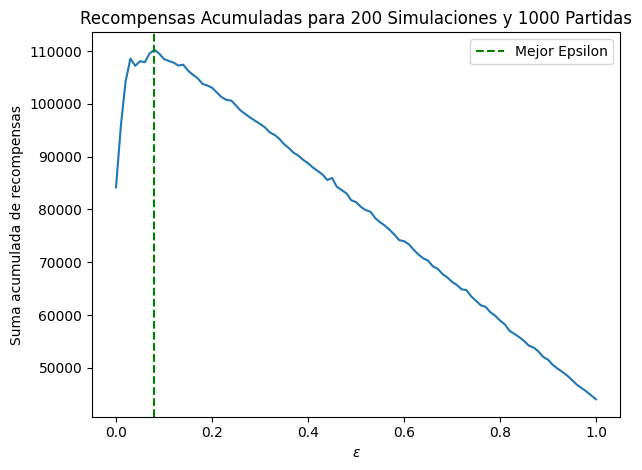

In [12]:
plt.plot(epsilons, acum_total_rewards)
plt.axvline(x = epsilons[np.argmax(acum_total_rewards)], color = "green", linestyle = "--", label = "Mejor Epsilon")
plt.xlabel("$\epsilon$")
plt.ylabel("Suma acumulada de recompensas")
plt.title(f"Recompensas Acumuladas para {n_sim} Simulaciones y 1000 Partidas")
plt.legend()
plt.tight_layout()

Así concluimos que el $\epsilon$ que maximiza la imagen con mayor número de clics es:

In [5]:
best_epsilon = epsilons[np.argmax(acum_total_rewards)]
print("El mejor epsilon es: {0}".format(best_epsilon))

El mejor epsilon es: 0.08


### Apartado 2

Para este apartado determinaremos qué imagen es la que obtiene más clics y cuántos obtiene. Al correr la simulación otra vez, esta inicializará las imágenes de forma aleatoria y no sabremos *a priori* qué imagen es la que ofrece la mayor recompensa, pero ya conocemos el valor de $\epsilon$ que maximiza la selección de esta imagen.

In [16]:
bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000,
                                                                           epsilon=best_epsilon,
                                                                           verbose=False)
print(f"Distribución de las imágenes\n{bandits}")
print(f"Nº de clics\n{num_selected_bandit * q_bandits}")
print(f"Nº impresiones de cada imagen\n{num_selected_bandit}")
print(f"Recompensa de las imágenes Q(a)\n{q_bandits.round(2)}")

Distribución de las imágenes
[0.1, 0.1, 0.6, 0.2, 0.1]
Nº de clics
[  0.   3. 551.   4.   1.]
Nº impresiones de cada imagen
[ 17.  18. 931.  18.  16.]
Recompensa de las imágenes Q(a)
[0.   0.17 0.59 0.22 0.06]


Vemos que la imagen que más clics obtiene es la que ofrece la mayor recompensa, la que recompensa el 60% de las veces. Por lo tanto, el valor de *epsilon* encontrado es realmente el mejor.

Text(0, 0.5, 'Nº de clics')

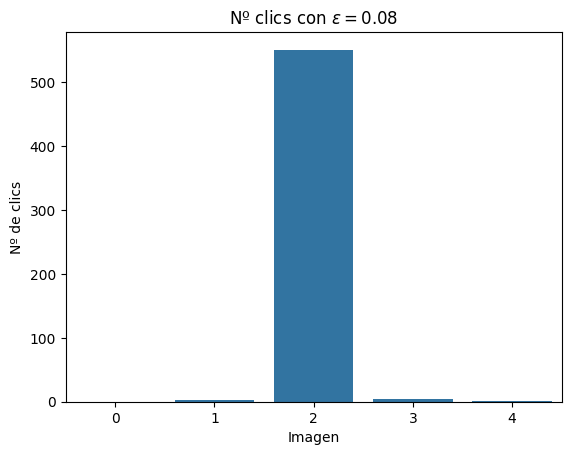

In [17]:
sns.barplot(data = num_selected_bandit * q_bandits)
plt.title(f"Nº clics con $\epsilon = {best_epsilon}$")
plt.xlabel("Imagen")
plt.ylabel("Nº de clics")

### Apartado 3

Si utilizamos un ratio de explotación del 100%, entonces $\epsilon = 0$ y el sistema solo explotará la primera imagen que ofrezca una recompensa. Tal y como hemos mencionado en el apartado 1 para *epsilon* muy cercanos a 0, en algunos casos es probable que el sistema escoja inicialmente al azar a la imagen que más recompensas ofrezca y obtengamos la máxima cantidad de recompensas posible todo el tiempo, aunque esta es una decisión con una alta variabilidad porque no siempre se escogerá la mejor imagen. De hecho, en la simulación de abajo la imagen 3 (cuyas recompensas son del 10%) ha sido la primera en dar una recompensa y el algoritmo ha explotado esta opción todo el tiempo, a pesar de no ser la imagen que más recompensas ofrece. Concluimos por tanto, que la política de solo explotación no es adecuada para maximizar el ROI.

Distribución de las imágenes:
[0.1, 0.1, 0.1, 0.2, 0.6]
Nº impresiones de cada imagen:
[  0.   0. 999.   1.   0.]


Text(0, 0.5, 'Nº de impresiones')

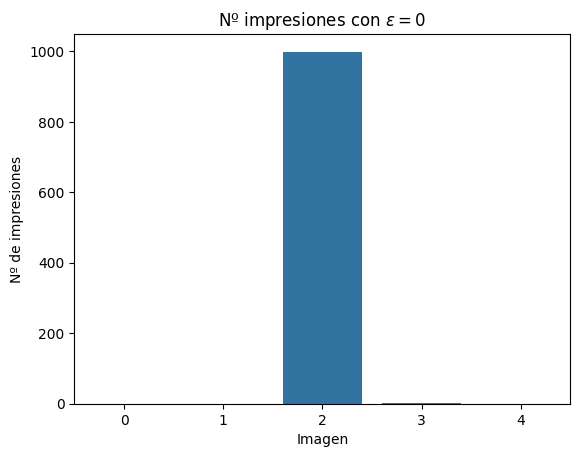

In [8]:
bandits, total_reward, q_bandits, num_selected_bandit = multi_armed_bandit(num_games=1000,
                                                                           epsilon=0.0,
                                                                           verbose=False)

print("Distribución de las imágenes:\n{0}".format(bandits))
print("Nº impresiones de cada imagen:\n{0}".format(num_selected_bandit))

sns.barplot(data = num_selected_bandit)
plt.title("Nº impresiones con $\epsilon = 0$")
plt.xlabel("Imagen")
plt.ylabel("Nº de impresiones")

### Conclusión

En este caso práctico se ha estudiado la implementación del algoritmo del bandido multibrazo aplicándolo a una campaña de marketing con 5 imágenes disponibles. Tras abordar el problema pertinentemente, hemos encontrado el valor $\epsilon$ que maximiza la utilización de la imagen que recompensa con más clics, y por ende maximiza el ROI de nuestra campaña de marketing. Asimismo, también hemos explicado cómo afecta a la pólitica *epsilon-greedy* valores de un 100% de explotación, concluyendo que no es la mejor decisión a largo plazo por su alto coste de oportunidad.